What the paper may still need is a solid explanation of what generally makes a site active
How do we say what the most typical active sites look like?
Chemical intuition will come from thinking about properties of the graphs, so it may still be valuable to discuss the success of the classifier restricted to graph-based features to justify the use of QM
We can also frame this within a discussion of what specific properties we typically see in the graph around the active sites
RDKit fingerprints do address this approach, but problems with kekulization make them kind of annoying and they don't know how to abstract the important details from things that just happen to be common in our distribution

Which questions about the graph would be worth answering?
Could have a plots that show active vs inactive for various graph-based features
Ortho, meta, para, further than 3
RingEdge: ring_edge, embedded_ring, neither (sp3 or non-ring)

Confusion matrices would be fine for binary features, but since these options are mutually exclusive there should be a better way to represent this. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 20})

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier

# Data Analysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

plt.rcParams.update({'font.size': 20})
import seaborn as sns

In [2]:
from ngcc_ml import data_tools

In [3]:
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv", index_col=0)

In [4]:
print(df.columns)

Index(['Atom Number', 'Catalyst Name', 'CatalystO2File', 'Element',
       'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge'],
      dtype='object')


In [5]:
df = df[df["Catalyst Name"] != "sf7x0"]

In [6]:
df[df["Catalyst Name"] == "sf268x0"][["Atom Number", "Catalyst Name", "CatalystO2File", "Doesitbind"]]

,Atom Number,Catalyst Name,CatalystO2File,Doesitbind
2759,1,sf268x0,sf268x0O2-0_optsp_a0m2.out,False
2760,2,sf268x0,None,False
2761,3,sf268x0,sf268x0O2-2_optsp_a0m2.out,False
2762,4,sf268x0,sf268x0O2-3_optsp_a0m2.out,False
2763,5,sf268x0,sf268x0O2-4_optsp_a0m2.out,False
2764,6,sf268x0,None,False
2765,7,sf268x0,None,False
2766,8,sf268x0,sf268x0O2-7_optsp_a0m2.out,False
2767,9,sf268x0,sf268x0O2-8_optsp_a0m2.out,False
2768,11,sf268x0,sf268x0O2-10_optsp_a0m2.out,False


In [7]:
df_active = df[df["Doesitbind"] == 1]

In [8]:
df_inactive = df[df["Doesitbind"] == 0]

In [9]:
RingEdge_inactive = dict(df_inactive["RingEdge"].value_counts())
RingEdge_active = dict(df_active["RingEdge"].value_counts())

In [10]:
# need % values to plot
rep = {}
antirep = {}
for key in RingEdge_active.keys():
    rep[key] = 100*RingEdge_active[key] / (RingEdge_active[key] + RingEdge_inactive[key])
    antirep[key] = 100 - rep[key]

In [11]:
rep

{2: 25.29212212589521, 1: 6.602768903088392, 0: 1.092896174863388}

In [12]:
df_active["DistanceToN"].value_counts()

1    417
3    238
2     71
5      9
4      3
7      1
Name: DistanceToN, dtype: int64

In [13]:
df_inactive["DistanceToN"].value_counts()

2     1139
3      657
1      620
4      443
5      243
6      114
7       60
8       31
9       19
10      14
12      11
11      10
13       8
14       8
15       5
16       5
18       2
17       2
23       1
26       1
20       1
22       1
24       1
21       1
28       1
27       1
25       1
19       1
29       1
Name: DistanceToN, dtype: int64

In [14]:
df_plot = df.copy()
df_plot.rename(columns={"Doesitbind": "Active Site"}, inplace=True)

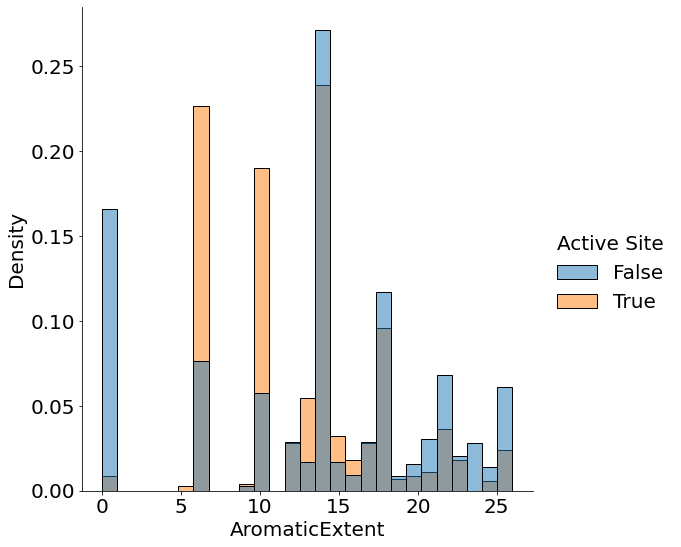

In [15]:

sns_plot = sns.displot(df_plot, x="AromaticExtent", hue="Active Site", stat="density", common_norm=False,
           height=8)
sns_plot.savefig("AromaticExtent_snsdisplot.png")

(array([543.,   0.,   0.,   0.,   0.,   0., 251.,   0.,   0.,   0.,   9.,
        189.,   0.,  95.,   0.,  56., 888.,  55.,  30.,  95., 383.,  29.,
          0.,  51., 100., 223.,  67.,  92.,  45., 201.]),
 array([ 0.        ,  0.86666667,  1.73333333,  2.6       ,  3.46666667,
         4.33333333,  5.2       ,  6.06666667,  6.93333333,  7.8       ,
         8.66666667,  9.53333333, 10.4       , 11.26666667, 12.13333333,
        13.        , 13.86666667, 14.73333333, 15.6       , 16.46666667,
        17.33333333, 18.2       , 19.06666667, 19.93333333, 20.8       ,
        21.66666667, 22.53333333, 23.4       , 24.26666667, 25.13333333,
        26.        ]),
 <BarContainer object of 30 artists>)

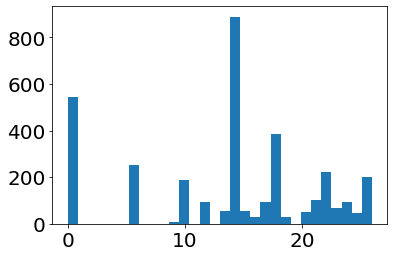

In [16]:
plt.hist(df_inactive["AromaticExtent"], bins=30)

In [17]:
df[(df["DistanceToN"] == 1) & (df["RingEdge"] == 2)]["Doesitbind"].astype(int).value_counts()

1    358
0    182
Name: Doesitbind, dtype: int64

In [18]:
358/(358+182)

0.662962962962963

In [19]:
dtn_inact = dict(df_inactive[df_inactive["DistanceToN"] <= 5]["DistanceToN"].value_counts())
gt5_inact = df_inactive[df_inactive["DistanceToN"] > 5]["DistanceToN"].value_counts().sum()
dtn_inact[6] = gt5_inact
print(dtn_inact)
print(gt5_inact)

{2: 1139, 3: 657, 1: 620, 4: 443, 5: 243, 6: 300}
300


In [20]:
dtn_act = dict(df_active[df_active["DistanceToN"] <= 5]["DistanceToN"].value_counts())
gt5_act = df_active[df_active["DistanceToN"] > 5]["DistanceToN"].value_counts().sum()
dtn_act[6] = gt5_act
print(dtn_act)

{1: 417, 3: 238, 2: 71, 5: 9, 4: 3, 6: 1}


In [35]:
def bar_grid(d_active, d_inactive, figname, xtick_input_labels=None, xlabel=""):
    rep = {}
    antirep = {}
    for key in d_active.keys():
        rep[key] = 100*d_active[key] / (d_active[key] + d_inactive[key])
        antirep[key] = 100 - rep[key]

    fig = plt.figure(figsize=(7,10))
    ax = plt.subplot(111)
    plt.bar(rep.keys(), list(rep.values()), label="Active", color="blue")
    plt.bar(rep.keys(), list(antirep.values()), bottom=list(rep.values()), label="Inactive", color="red")
    ax.set_yticks([0,20,40,60,80,100])
    ax.set_yticklabels([str(i)+"%" for i in [0,20,40,60,80,100]])
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.ylim([0,100])
    if xtick_input_labels == None:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        #ax.set_xticks(np.arange(0, len(xtick_input_labels)))
        ax.set_xticks(np.arange(1, len(xtick_input_labels)+1))
        ax.set_xticklabels(xtick_input_labels)
    #plt.show()
    plt.xlabel(xlabel)
    plt.savefig(figname, bbox_inches="tight")

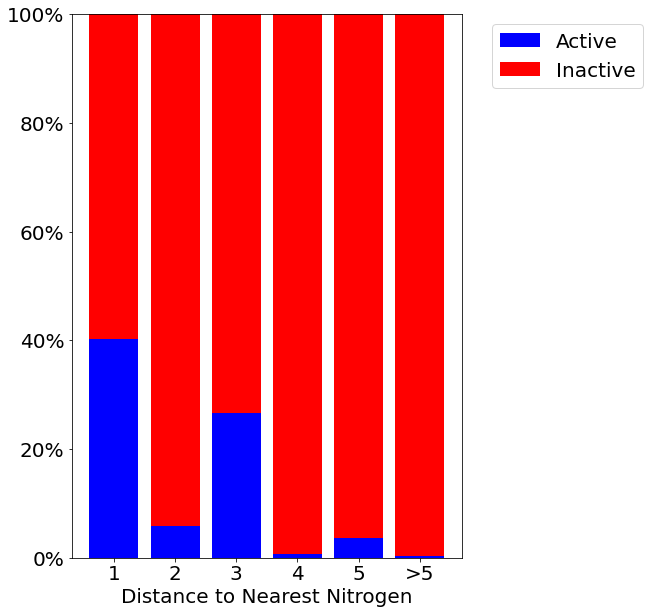

In [36]:
bar_grid(dtn_act, dtn_inact, "DistanceToN_stackbar.png", xtick_input_labels=["1","2","3","4","5",">5"], xlabel="Distance to Nearest Nitrogen")

In [23]:
shared_rings_active = {0:RingEdge_active[0], 1:RingEdge_active[2], 2:RingEdge_active[1]}
shared_rings_inactive = {0:RingEdge_inactive[0], 1:RingEdge_inactive[2], 2:RingEdge_inactive[1]}
shared_rings_active

{0: 6, 1: 671, 2: 62}

In [24]:
shared_rings_inactive

{0: 543, 1: 1982, 2: 877}

In [25]:
print(6/549)
print(671/(671+1982))
print(62/(62+877))

0.01092896174863388
0.2529212212589521
0.06602768903088392


In [26]:
print(549)
print((671+1982))
print((62+877))

549
2653
939


In [30]:
shared_rings_active

{0: 6, 1: 671, 2: 62}

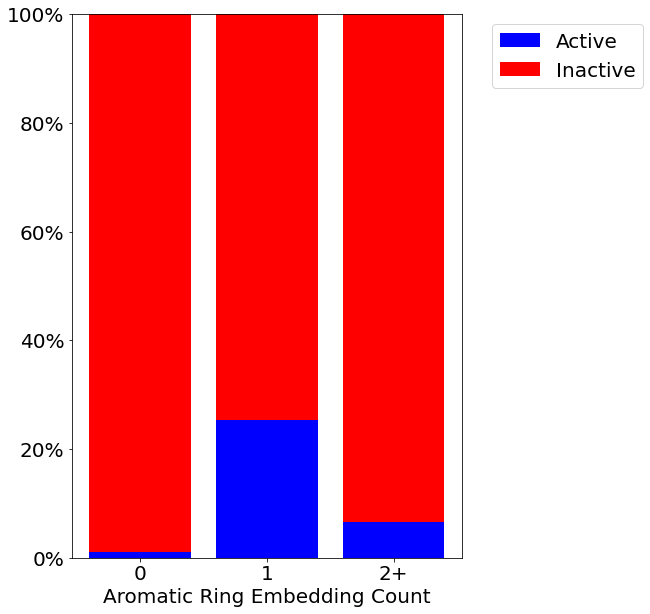

In [34]:
bar_grid(shared_rings_active, shared_rings_inactive, "SharedRings_stackbar.png", xtick_input_labels=["0","1","2+"], xlabel="Aromatic Ring Embedding Count")

In [19]:
rep.values()

dict_values([25.29212212589521, 6.602768903088392, 1.092896174863388])

In [94]:
from itertools import product

In [95]:
abra = [[256, 512], [128, 256], [64, 128], [32], [16], [8]]

In [98]:
[print(l) for l in product(*abra)]

(256, 128, 64, 32, 16, 8)
(256, 128, 128, 32, 16, 8)
(256, 256, 64, 32, 16, 8)
(256, 256, 128, 32, 16, 8)
(512, 128, 64, 32, 16, 8)
(512, 128, 128, 32, 16, 8)
(512, 256, 64, 32, 16, 8)
(512, 256, 128, 32, 16, 8)


[None, None, None, None, None, None, None, None]